In [1]:
import pandapower as pp
import pandapower.networks as pn
from pandapower.plotting import simple_plot

import pandas as pd
import numpy as np
from numpy.random import default_rng
import cvxpy as cp
import networkx as nx
import mosek
import custom_networks

from solution_files_manager import SolutionFilesManager
from opt_utils import decompose_psd, complex_hyperplane_rounding, fixed_point_iteration
from opf_utils import *

In [2]:
import os
folder = os.path.abspath(os.getcwd())

## Data processing

In [3]:
case = "case9"
net = custom_networks.get_case(case)
n = len(net.bus)

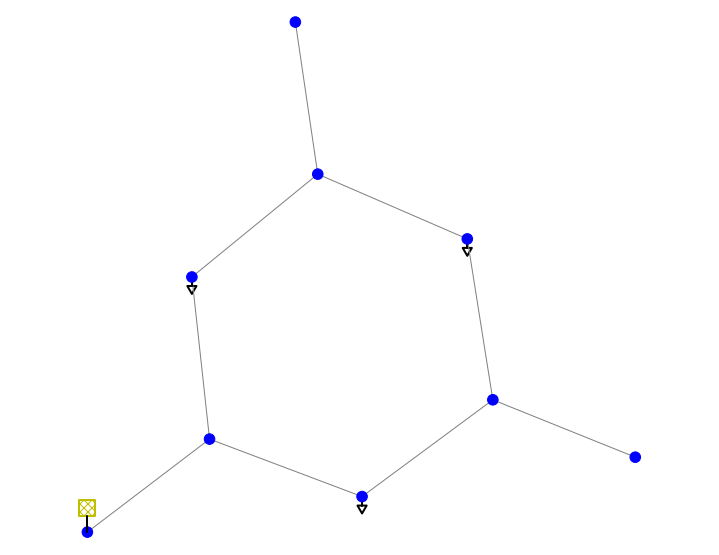

<AxesSubplot:>

In [4]:
simple_plot(net, plot_loads=True, plot_sgens=True)

#### Generators

In [5]:
gen_df_list = []
gen_class_list = ["ext_grid", "gen", "sgen"]  # the 3 types of generators
data_col_list = ["bus", "max_p_mw", "min_p_mw", "max_q_mvar", "min_q_mvar"]

for gen_class in gen_class_list:
    if not net[gen_class].empty:
        # get a table of cost coefficients only for the current type of generators
        gen_class_poly_cost = net.poly_cost.loc[net.poly_cost.et == gen_class].set_index("element")
        # get a table of cost coefficients and power bounds only for the current type of generators
        gen_class_df = net[gen_class][data_col_list].join(gen_class_poly_cost)
        gen_df_list.append(gen_class_df)

# combine tables for all types of generators
gen_df = pd.concat(gen_df_list).reset_index()
n_gen = len(gen_df)
gens = gen_df["bus"].to_numpy()

In [6]:
gen_df

,index,bus,max_p_mw,min_p_mw,max_q_mvar,min_q_mvar,et,cp0_eur,cp1_eur_per_mw,cp2_eur_per_mw2,cq0_eur,cq1_eur_per_mvar,cq2_eur_per_mvar2
0,0,0,250.0,10.0,300.0,-300.0,ext_grid,150.0,5.0,0.1100,0.0,0.0,0.0
1,0,1,300.0,10.0,300.0,-300.0,gen,600.0,1.2,0.0850,0.0,0.0,0.0
2,1,2,270.0,10.0,300.0,-300.0,gen,335.0,1.0,0.1225,0.0,0.0,0.0


#### Bus loads

In [7]:
load_df = net.bus.join(net.load[["bus", "p_mw", "q_mvar"]].set_index("bus")).fillna(0)[["p_mw", "q_mvar"]]

In [8]:
load_df

,p_mw,q_mvar
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,90.0,30.0
5,0.0,0.0
6,100.0,35.0
7,0.0,0.0
8,125.0,50.0


#### Admittance matrices

In [9]:
# obtain a NetworkX Graph from the network, with each edge containing p.u. impedance data
graph = pp.topology.create_nxgraph(net, multi=False, calc_branch_impedances=True, branch_impedance_unit="pu")

In [10]:
# compute non-diagonal entries of the admittance matrices (opposite of mutual admittance on each line)
G_val = np.zeros((n,n))
B_val = np.zeros((n,n))
for i,j in graph.edges:
    edge = graph.edges[(i,j)]
    r = edge["r_pu"]
    x = edge["x_pu"]
    z = r + x*1j
    y = np.reciprocal(z)
    G_val[i][j] = G_val[j][i] = -np.real(y)
    B_val[i][j] = B_val[j][i] = -np.imag(y)

In [11]:
# compute line susceptance in p.u.
net.line['s_pu'] = net.line['c_nf_per_km'] * net.line["length_km"] * (2 * np.pi * net.f_hz) * \
    ((net.bus.loc[net.line.from_bus.values, "vn_kv"].values) ** 2) / net.sn_mva / net.line['parallel'] / 1e9

In [12]:
# compute intermediate values that will sum to the diagonal entries of G and B
G_interm = -np.copy(G_val)
B_interm = -np.copy(B_val)

# add line susceptance
for _, row in net.line.iterrows():
    B_interm[row["from_bus"]][row["to_bus"]] += row["s_pu"] / 2
    B_interm[row["to_bus"]][row["from_bus"]] += row["s_pu"] / 2

# transformers
for _, row in net.trafo.iterrows():
    h = row["hv_bus"]
    l = row["lv_bus"]
    ratio_magnitude = (row["vn_hv_kv"] / row["vn_lv_kv"]) * (net.bus.loc[l]["vn_kv"] / net.bus.loc[h]["vn_kv"])
    ratio_sq = ratio_magnitude**2
    G_interm[h][l] /= ratio_sq
    B_interm[h][l] /= ratio_sq
    G_interm[l][h] *= ratio_sq
    B_interm[l][h] *= ratio_sq
    # shift degrees
    if row["tap_phase_shifter"]:
        theta = row["shift_degree"]
        ratios_denom = np.exp(-1j * (2 * theta / 180 * np.pi))
        G_val[h][l] /= ratios_denom
        B_val[h][l] /= ratios_denom
        G_val[l][h] *= ratios_denom
        B_val[l][h] *= ratios_denom
    
G_row_sums = np.sum(G_interm, axis=1)
B_row_sums = np.sum(B_interm, axis=1)
for i in range(n):
    shunt_row = net.shunt.loc[net.shunt["bus"] == i]
    g = 0  # shunt conductance
    b = 0  # shunt susceptance
    # if both are 0, there will be no data in the shunt dataframe
    if not shunt_row.empty:
        g = shunt_row["p_mw"] / net.sn_mva
        b = -shunt_row["q_mvar"] / net.sn_mva  # the pandapower data store negative shunt susceptance
    G_val[i][i] = g + G_row_sums[i]
    B_val[i][i] = b + B_row_sums[i]

Y_val = G_val + B_val * 1j

## Variables

In [13]:
# X = VV*
X = cp.Variable((n,n), hermitian=True)
# active power generated
p_g = cp.Variable((n_gen, 1))
# reactive power generated
q_g = cp.Variable((n_gen, 1))

## Parameters

In [14]:
p_d_val = load_df[["p_mw"]].to_numpy() / net.sn_mva
q_d_val = load_df[["q_mvar"]].to_numpy() / net.sn_mva

In [15]:
# loads
p_d = cp.Parameter((n,1), nonneg=True, value=p_d_val)
q_d = cp.Parameter((n,1), value=q_d_val)

# admittance matrices
G = cp.Parameter((n,n), symmetric=True, value=G_val)
B = cp.Parameter((n,n), symmetric=True, value=B_val)
Y = cp.Parameter((n,n), complex=True, value=Y_val)

# squares of voltage bounds
V_min_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["min_vm_pu"].to_numpy()))
V_max_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["max_vm_pu"].to_numpy()))

# bounds for generated power
# TODO: check whether these are for net injections (supply - demand) or for generated power (supply)
p_min = cp.Parameter((n_gen,1), value=gen_df[["min_p_mw"]].to_numpy() / net.sn_mva)
p_max = cp.Parameter((n_gen,1), value=gen_df[["max_p_mw"]].to_numpy() / net.sn_mva)
q_min = cp.Parameter((n_gen,1), value=gen_df[["min_q_mvar"]].to_numpy() / net.sn_mva)
q_max = cp.Parameter((n_gen,1), value=gen_df[["max_q_mvar"]].to_numpy() / net.sn_mva)

In [16]:
# vectors of cost coefficients: c_[p or q]_[power]
# costs are only on generators

c_p_2 = cp.Parameter((n_gen), value=gen_df["cp2_eur_per_mw2"].to_numpy() * (net.sn_mva**2), nonneg=True)
c_p_1 = cp.Parameter((n_gen), value=gen_df["cp1_eur_per_mw"].to_numpy() * net.sn_mva, nonneg=True)
c_p_0 = cp.Parameter((n_gen), value=gen_df["cp0_eur"].to_numpy(), nonneg=True)

c_q_2 = cp.Parameter((n_gen), value=gen_df["cq2_eur_per_mvar2"].to_numpy() * (net.sn_mva**2), nonneg=True)
c_q_1 = cp.Parameter((n_gen), value=gen_df["cq1_eur_per_mvar"].to_numpy() * net.sn_mva, nonneg=True)
c_q_0 = cp.Parameter((n_gen), value=gen_df["cq0_eur"].to_numpy(), nonneg=True)

## Constraints

##### SOCP

In [17]:
# constraints = [ cp.quad_over_lin(cp.norm(X[i][j]), cp.real(X[i][i])) <= cp.real(X[j][j]) for i,j in graph.edges]

##### SDP

In [29]:
constraints = [X >> 0]

for i in range(n):
    gen_list = gen_df.loc[gen_df["bus"] == i].index.to_numpy()
    constraints += [
        cp.sum([p_g[k] for k in gen_list]) - p_d[i] == G[i][i] * X[i][i] +
        cp.sum([G[i][j] * cp.real(X[i][j]) + B[i][j] * cp.imag(X[i][j]) for j in graph.neighbors(i)])
    ]
    constraints += [
        cp.sum([q_g[k] for k in gen_list]) - q_d[i] == -B[i][i] * X[i][i] +
        cp.sum([-B[i][j] * cp.real(X[i][j]) + G[i][j] * cp.imag(X[i][j]) for j in graph.neighbors(i)])
    ]

constraints += [
    cp.real(cp.diag(X)) >= V_min_sq,
    cp.real(cp.diag(X)) <= V_max_sq
]

constraints += [
    p_g >= p_min,
    p_g <= p_max,
    q_g >= q_min,
    q_g <= q_max
]

In [30]:
p_cost = c_p_2 @ cp.square(p_g) + c_p_1 @ p_g + cp.sum(c_p_0)
q_cost = c_q_2 @ cp.square(q_g) + c_q_1 @ q_g + cp.sum(c_q_0)

## Modified constraints

In [38]:
Phis = []
Psis = []
for i in range(n):
    J_i = np.zeros((n,n))
    J_i[i][i] = 1
    Y_i = J_i @ Y
    Phi_i = 1 / 2 * (Y_i.H + Y_i)
    Phis.append(Phi_i)
    Psi_i = 1 / 2j * (Y_i.H - Y_i)
    Psis.append(Psi_i)

In [39]:
constraints = [X >> 0]

for i in range(n):
    # TODO: multiple generators at one bus
    if i in gens:
        i_gen_idx = list(gens).index(i)
        constraints += [ cp.real(cp.trace(Phis[i] @ X)) + p_d[i] <= p_max[i_gen_idx] ]
        constraints += [ cp.real(cp.trace(Phis[i] @ X)) + p_d[i] >= p_min[i_gen_idx] ]
        constraints += [ cp.real(cp.trace(Psis[i] @ X)) + q_d[i] <= q_max[i_gen_idx] ]
        constraints += [ cp.real(cp.trace(Psis[i] @ X)) + q_d[i] >= q_min[i_gen_idx] ]
    else:
        constraints += [ cp.real(cp.trace(Phis[i] @ X)) == -p_d[i] ]
        constraints += [ cp.real(cp.trace(Psis[i] @ X)) == -q_d[i] ]

constraints += [
    cp.real(cp.diag(X)) >= V_min_sq,
    cp.real(cp.diag(X)) <= V_max_sq
]

In [40]:
p_cost = cp.sum([ c_p_2[i] * cp.square((cp.real(cp.trace(Phis[gens[i]] @ X)) + p_d[gens[i]])) + c_p_1[i] * (cp.real(cp.trace(Phis[gens[i]] @ X)) + p_d[gens[i]]) for i in range(n_gen) ]) + cp.sum(c_p_0)
q_cost = cp.sum([ c_q_2[i] * cp.square((cp.real(cp.trace(Psis[gens[i]] @ X)) + p_d[gens[i]])) + c_q_1[i] * (cp.real(cp.trace(Psis[gens[i]] @ X)) + q_d[gens[i]]) for i in range(n_gen) ]) + cp.sum(c_q_0)

## Solving

In [48]:
prob = cp.Problem(cp.Minimize(p_cost + q_cost), constraints)

In [49]:
# prob.solve(solver=cp.SCS, verbose=True)  # eps=1e-6
# prob.solve(solver=cp.CVXOPT, verbose=True)
prob.solve(solver=cp.MOSEK, mosek_params={mosek.iparam.intpnt_solve_form : mosek.solveform.dual}, verbose=False)

# Print result.
print("The optimal value is", prob.value)
# print("A solution X is")
# print(X.value)

The optimal value is 5296.686024086754


/home/ivanightingale/miniconda3/envs/convex/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


In [43]:
print(p_g.value)
print(q_g.value)

[[0.89798273]
 [1.34320365]
 [0.94188053]]
[[0.12977966]
 [0.05796688]
 [0.08628408]]


In [29]:
# sfm = SolutionFilesManager(folder, case, "sdp")
# sfm.save_solution(prob.value, X, p_g, q_g)

In [30]:
# # recover V by diagonalization using the largest eigenvalue
# (eigen_val, eigen_vec) = np.linalg.eigh(X.value)
# V = np.sqrt(eigen_val[n-1]) * eigen_vec[:,n-1]

# Test

##### Find interior point

In [44]:
X_ac = cp.Variable((n,n), hermitian=True)

In [45]:
prob_ac = cp.Problem(cp.Maximize(cp.log_det(X_ac) \
                              + cp.sum([ cp.log(p_max[i] - cp.real(cp.trace(Phis[i] @ X_ac)) - p_d[gens[i]]) + cp.log(cp.real(cp.trace(Phis[i] @ X_ac)) + p_d[gens[i]] - p_min[i]) for i in range(n_gen) ]) \
                              + cp.sum([ cp.log(q_max[i] - cp.real(cp.trace(Psis[i] @ X_ac)) - q_d[gens[i]]) + cp.log(cp.real(cp.trace(Psis[i] @ X_ac)) + q_d[gens[i]] - q_min[i]) for i in range(n_gen) ]) \
                              + cp.sum([ cp.log(V_max_sq[i] - cp.real(X_ac[i][i])) + cp.log(cp.real(X_ac[i][i]) - V_min_sq[i]) for i in range(n) ]) ), constraints)

prob_ac.solve(solver=cp.SCS)

-25.95550002568475

### Fixed point iterations

In [50]:
# fixed_point_iteration(prob, X, np.zeros((n,n)), True)
fixed_point_iteration(prob, X, -X_ac.value, True)

Initial objective:  5296.686024086754
Initial rank:  9
Current objective:  5535.482075518804
Current rank:  4
Current objective:  5955.826117711595
Current rank:  3
Current objective:  6424.235497034275
Current rank:  4
Current objective:  6867.577082522338
Current rank:  3
Current objective:  7260.511104145627
Current rank:  8
Current objective:  7600.8781546635455
Current rank:  9
Current objective:  7745.201245007713
Current rank:  4
Current objective:  7823.920300182146
Current rank:  3
Current objective:  7886.526453661357
Current rank:  3
Current objective:  7935.978273674067
Current rank:  3
Current objective:  7974.813545044274
Current rank:  3
Current objective:  8005.176380036068
Current rank:  3
Current objective:  8028.834420639402
Current rank:  3
Current objective:  8047.219948340216
Current rank:  3
Current objective:  8061.479161064374
Current rank:  3
Current objective:  8072.520888458363
Current rank:  3
Current objective:  8081.06083791945
Current rank:  3
Current ob

### Hyperplane rounding

In [ ]:
def cost_from_exact_solution(v):
    X_exact = v @ v.conj().T
    p_g, q_g = compute_generation(X_exact, n_gen, p_d_val, q_d_val, G_val, B_val, graph)
    p_cost = np.sum(c_p_2.value @ np.square(p_g) + c_p_1.value @ p_g + np.sum(c_p_0.value))
    q_cost = np.sum(c_q_2.value @ np.square(q_g) + c_q_1.value @ q_g + np.sum(c_q_0.value))
    return p_cost + q_cost

In [ ]:
# note that this usually results in an infeasible point
hyperplane_cost, hyperplane_v = complex_hyperplane_rounding(decompose_psd(X.value), cost_from_exact_solution, net.bus["min_vm_pu"].to_numpy(), net.bus["max_vm_pu"].to_numpy())
print(hyperplane_cost)

In [ ]:
check_power_feasibility(hyperplane_v, p_min.value, p_max.value, q_min.value, q_max.value, n_gen, p_d_val, q_d_val, G_val, B_val, graph)

### Verify correctness of constraints

In [ ]:
# load pandapower solution
sfm = SolutionFilesManager(folder, case, "orig")
_, V_orig, p_g_orig, q_g_orig = sfm.load_solution()

In [ ]:
X_orig = V_orig @ V_orig.conjugate().reshape(1,-1)

In [ ]:
verify_feasibility(X_orig, p_g_orig, q_g_orig, p_d_val, q_d_val, gen_df, G_val, B_val, graph)